In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
import pymc3 as pm

Text(0,0.5,'Quantity sold')

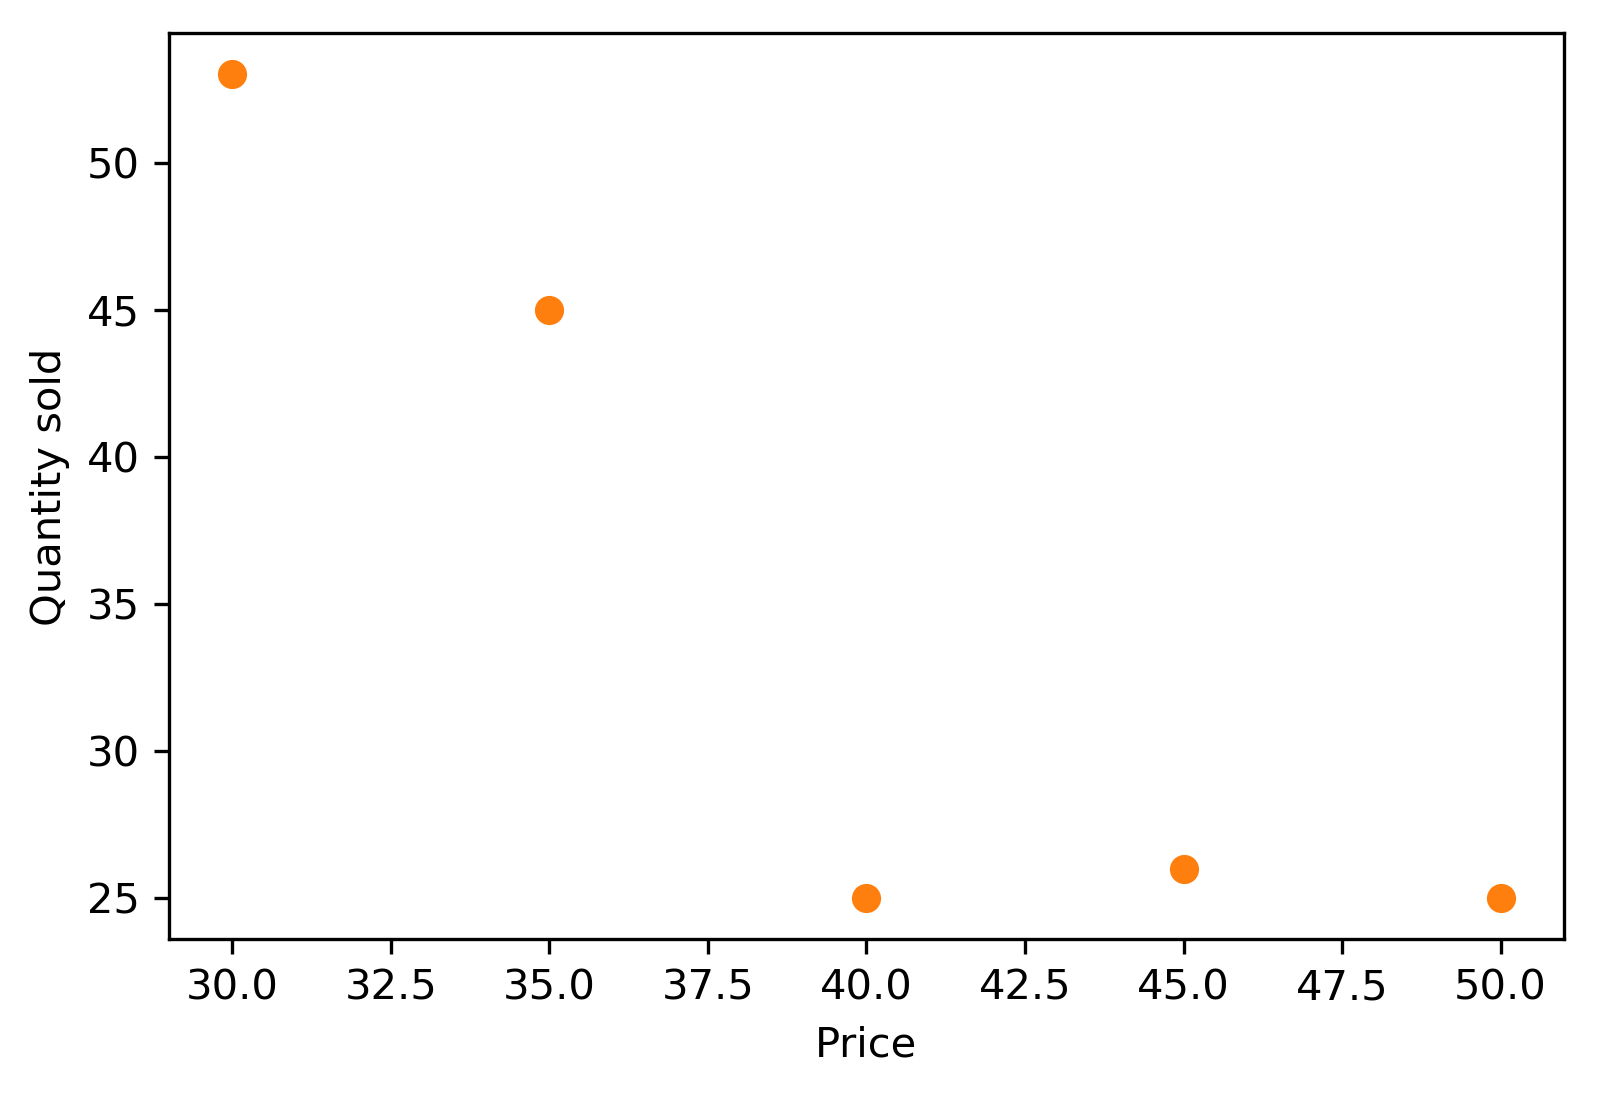

In [25]:
np.random.seed(42)
a = 50000
k = 20
c = -2
p  = np.linspace(25,55)
p0 = np.linspace(30,50,5)
eq = a * p**c
q0 = np.random.poisson(a * p0**c)
π = eq * (p - k)

# np.log(prices-k) + np.log(a) + c*np.log(prices)

#plt.plot(p,π);
plt.plot(p0,q0,'o',c='C1');
plt.xlabel('Price')
plt.ylabel('Quantity sold')

In [26]:
def fitprices(p0,q0,draws=500):
    with pm.Model() as m:
        α = pm.Cauchy('α',0,5)
        β = pm.Cauchy('β',0,5)
        logμ0 = α + β * (np.log(p0) - np.log(p0).mean())
        μ0 = pm.Deterministic('μ0',np.exp(logμ0))
        def logp(failure, value):
            pm.Poisson.dist()
            return (failure * log(λ) - λ * value).sum()

        qval = pm.Poisson('q0',μ0,observed=q0)
        
        return pm.sample(draws=draws)

In [27]:
def predict(t,p):
    a = np.array(t.α)
    b = np.array(t.β)
    μ = np.exp(a + b * (np.log(p).reshape(-1,1) - np.log(p0).mean()))
    π = (p - k).reshape(-1,1) * μ
    return (μ,π)

In [28]:
def plot(p):
    μ,π = predict(t,p)

    plt.plot(p,π,c='k',alpha=0.01);
    plt.plot(p,np.mean(π,1).T,c='C1',lw=2,label="$\mathbb{E}[\pi|P]$");
    plt.fill_between(p,(np.percentile(π,5,1)).T,(np.percentile(π,95,1)).T,alpha=0.1,color='C1')
    plt.plot(p,(np.percentile(π,5,1)).T,c='C1',lw=1,label="$\mathbb{E}[\pi|P]\ \pm$1 sd");
    plt.plot(p,(np.percentile(π,95,1)).T,c='C1',lw=1);
    pmax = p[np.argmax(np.mean(π,1))]
    plt.vlines(pmax,300,900,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[\pi|P]$")
    #plt.plot(p,(p - k) * eq)
    #plt.ylim(300,900);
    plt.xlabel("Price $P$")
    plt.ylabel("Profit $\pi$")
    plt.legend();

In [29]:
t = fitprices(p0,q0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
100%|██████████| 1000/1000 [00:00<00:00, 1267.11it/s]


In [30]:
pm.summary(t)

mean        sd  mc_error    hpd_2.5   hpd_97.5   n_eff      Rhat
α       3.494231  0.079859  0.001944   3.341067   3.657749  1628.0  1.000238
β      -1.703707  0.419977  0.009417  -2.537277  -0.907085  1834.0  0.999543
μ0__0  52.678440  6.358137  0.152239  40.093941  64.746846  1811.0  0.999458
μ0__1  40.354169  3.293690  0.080897  33.725774  46.605993  1711.0  0.999814
μ0__2  32.144012  2.631104  0.063089  26.793667  37.185302  1651.0  1.000261
μ0__3  26.368901  2.882011  0.066340  20.682423  32.138687  1696.0  1.000291
μ0__4  22.133372  3.189904  0.072087  15.965172  28.376361  1731.0  1.000257

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d8e2a8470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3d858cde10>]], dtype=object)

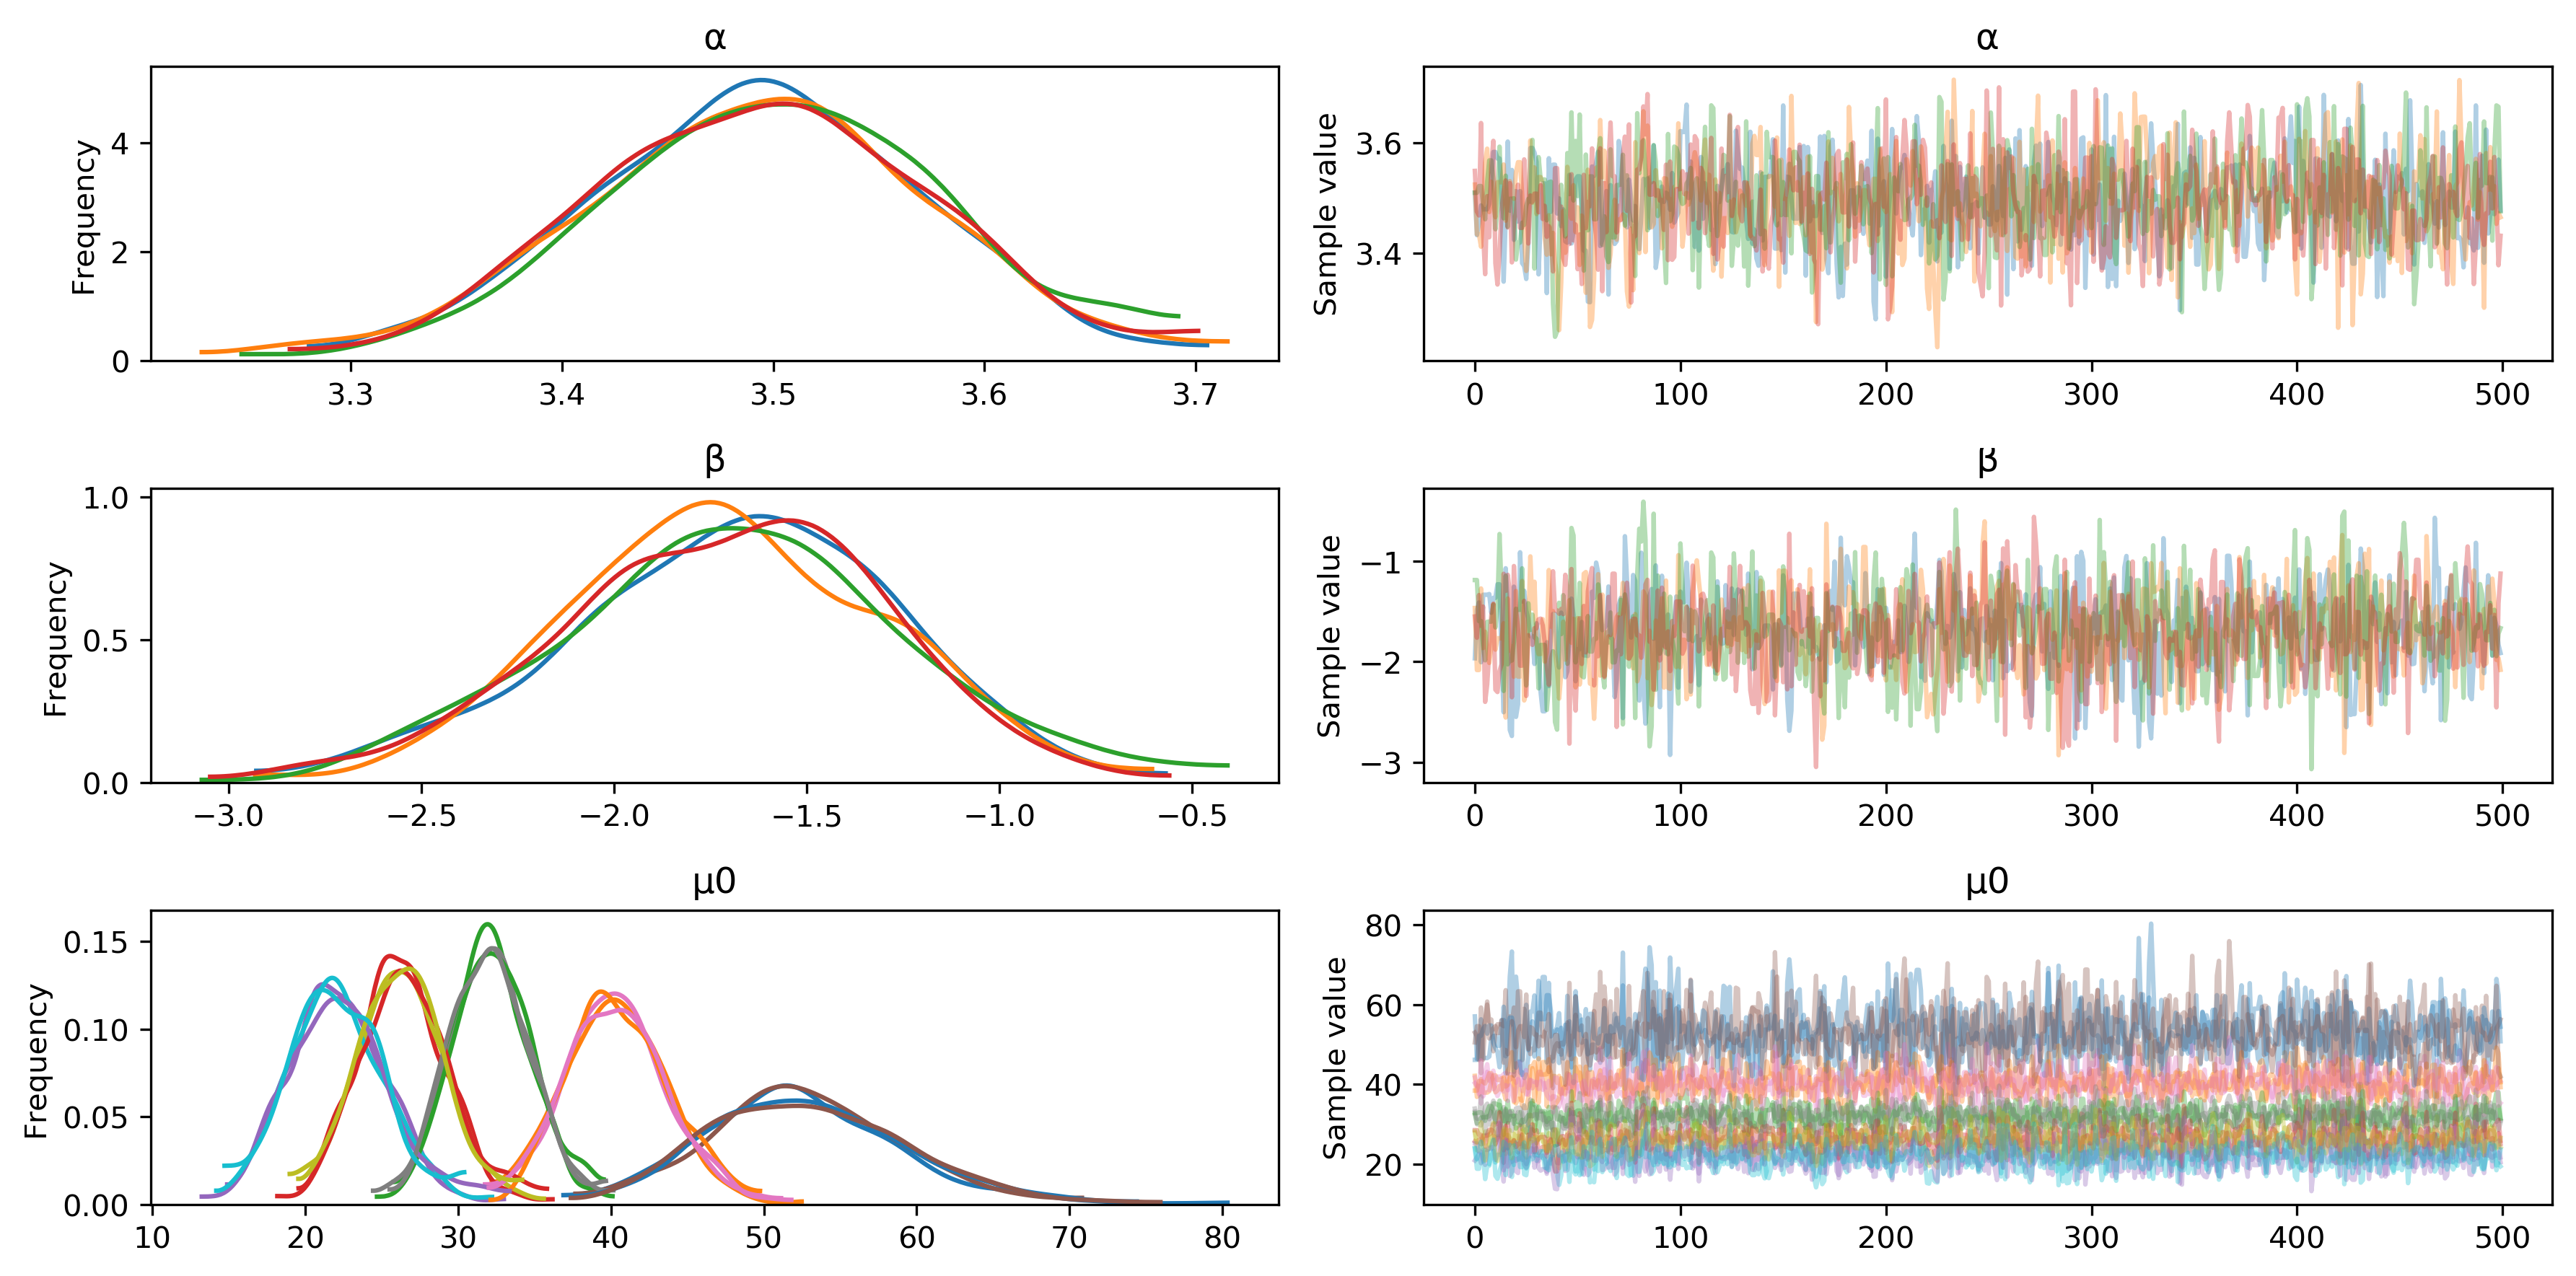

In [31]:
pm.traceplot(t)

In [32]:
p = np.linspace(25,55)
μ,π = predict(t,p)

(300, 900)

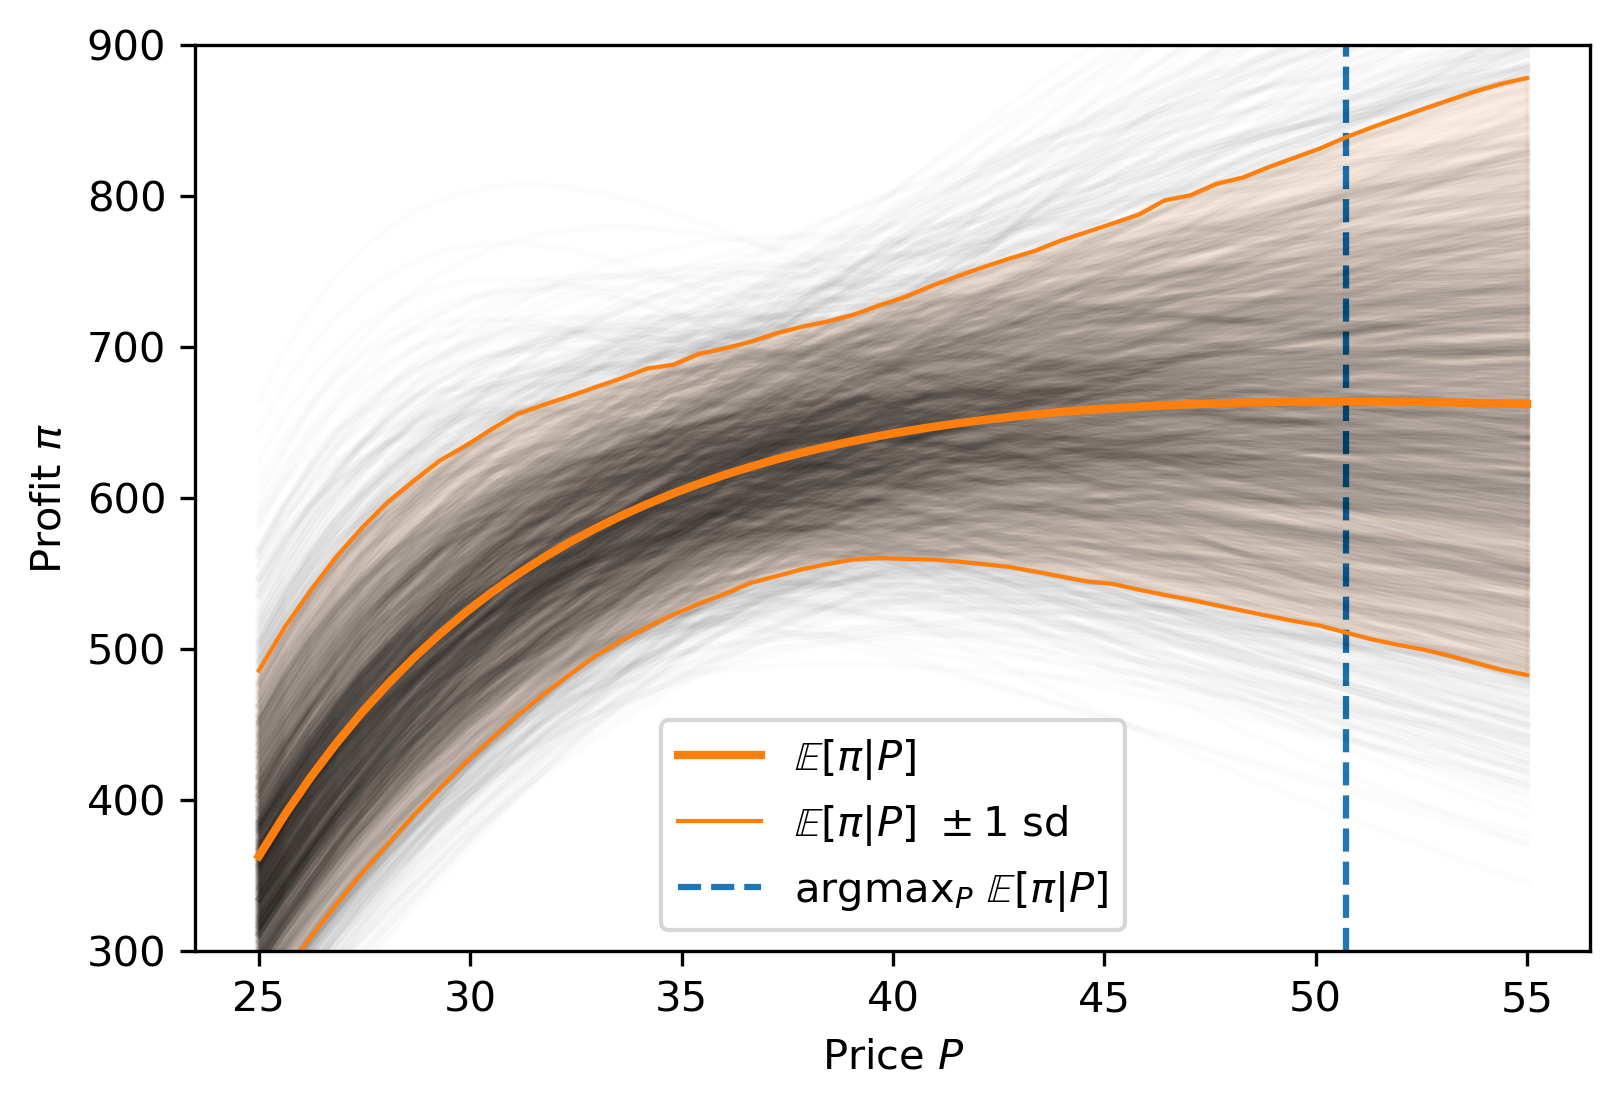

In [33]:
plot(p)
plt.ylim(300,900)

## Sensitivity

The $\mathbb{E}[\pi|P]$ curve appears to be very flat near our result, suggesting we really should look into how dependent our 

In [72]:
from sklearn.utils import resample

In [78]:
import pandas as pd
df = pm.trace_to_dataframe(t)

In [82]:
predict(df,p)

(array([[ 25.71611813,  25.38465805,  26.20606967, ...,  23.93381833,
          24.24856321,  26.6110086 ],
        [ 25.4883619 ,  25.21465985,  26.03932932, ...,  23.66947725,
          24.0934491 ,  26.47609759],
        [ 25.26363516,  25.04655819,  25.87439383, ...,  23.40922682,
          23.94001925,  26.34247364],
        ..., 
        [ 17.58842434,  19.05277739,  19.95390557, ...,  14.89520945,
          18.43631671,  21.41917031],
        [ 17.45986982,  18.9474978 ,  19.84915249, ...,  14.75941603,
          18.33901043,  21.32958448],
        [ 17.33272759,  18.84318809,  19.7453357 , ...,  14.6253585 ,
          18.24257661,  21.24070428]]),
 array([[ 642.90295324,  634.61645136,  655.15174169, ...,  598.34545816,
          606.21408032,  665.27521506],
        [ 642.41075403,  635.51234513,  656.2973819 , ...,  596.56743687,
          607.25325787,  667.30572499],
        [ 641.90256677,  636.38703972,  657.42082275, ...,  594.78545691,
          608.27191774,  669.31387

In [114]:
n = 10
p = np.linspace(45,55)
phats = np.zeros(n)
for j in range(n):
    t = fitprices(p0,q0)
    μ,π = predict(t,p)
    phats[j] = p[np.argmax(π.mean(1))]

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
INFO:pymc3:NUTS: [β, α]
100%|██████████| 1000/1000 [00:01<00:00, 775.04it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
INFO:pymc3:NUTS: [β, α]
100%|██████████| 1000/1000 [00:00<00:00, 1156.75it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

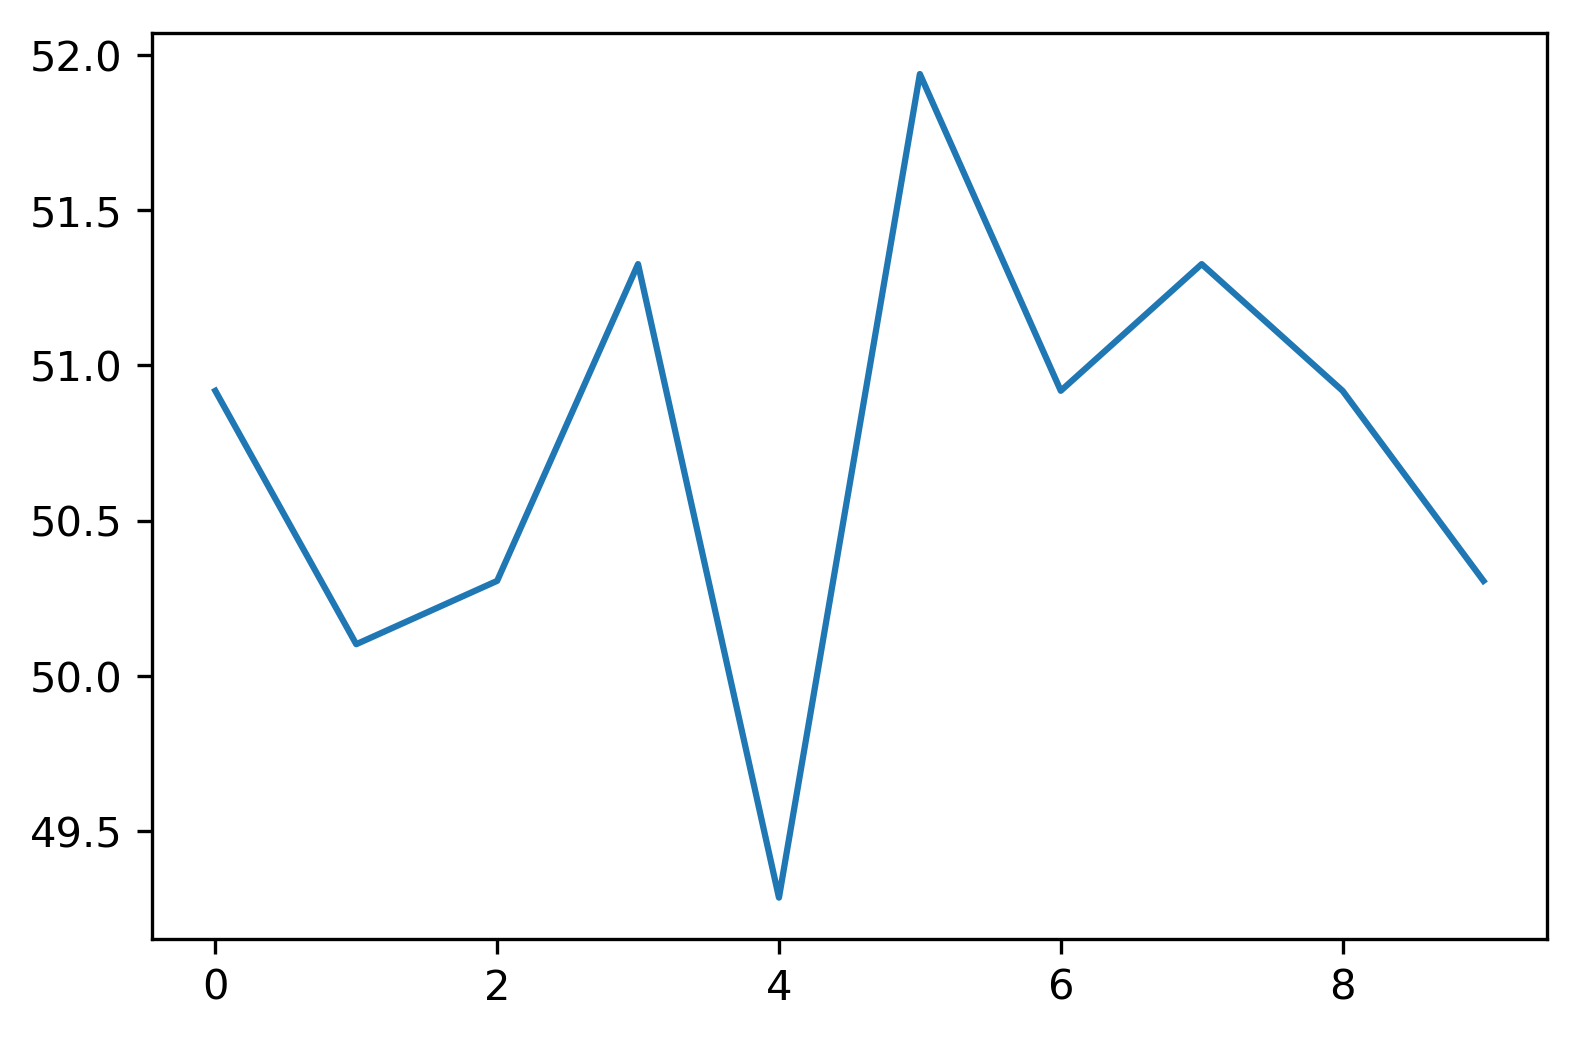

In [115]:
plt.plot(phats)

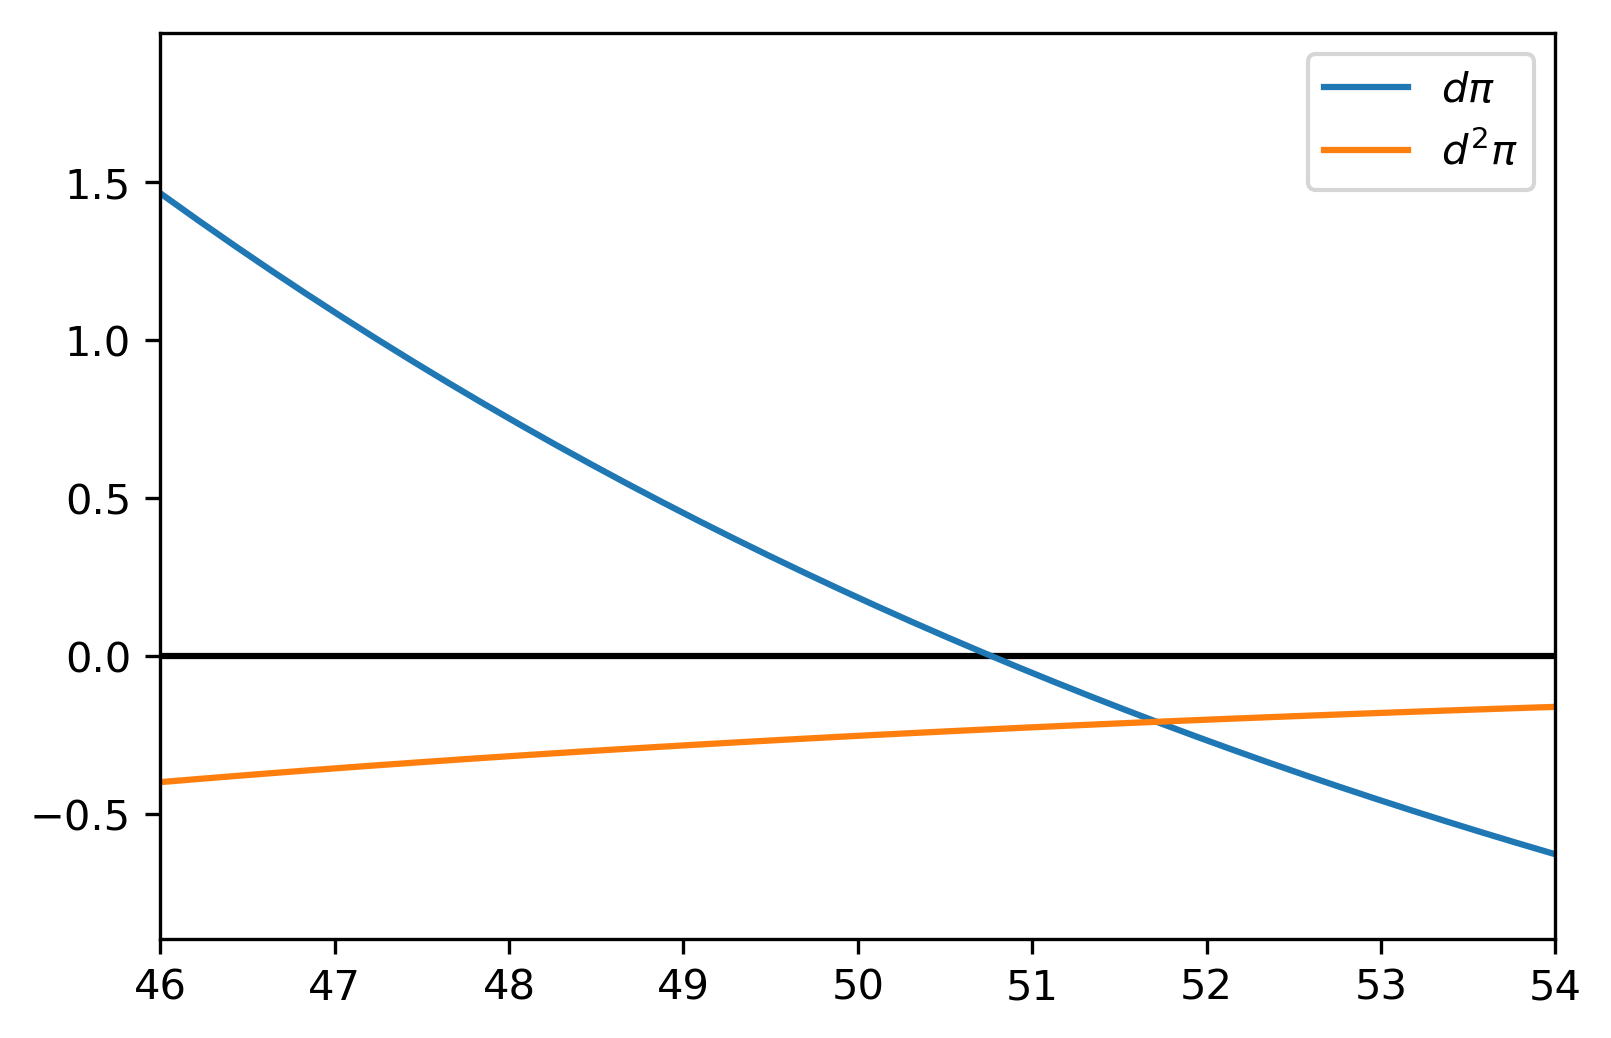

In [71]:
p = np.linspace(45,55)
μ,π = predict(t,p)
Δp = np.diff(p).mean()
dπ = np.gradient(np.mean(π,1),Δp)
d2π = np.gradient(dπ,Δp)
plt.plot(p,dπ,label="$d\pi$")
plt.plot(p,d2π,label="$d^2\pi$")
plt.hlines(0,45,55)
plt.xlim(46,54)
plt.legend()

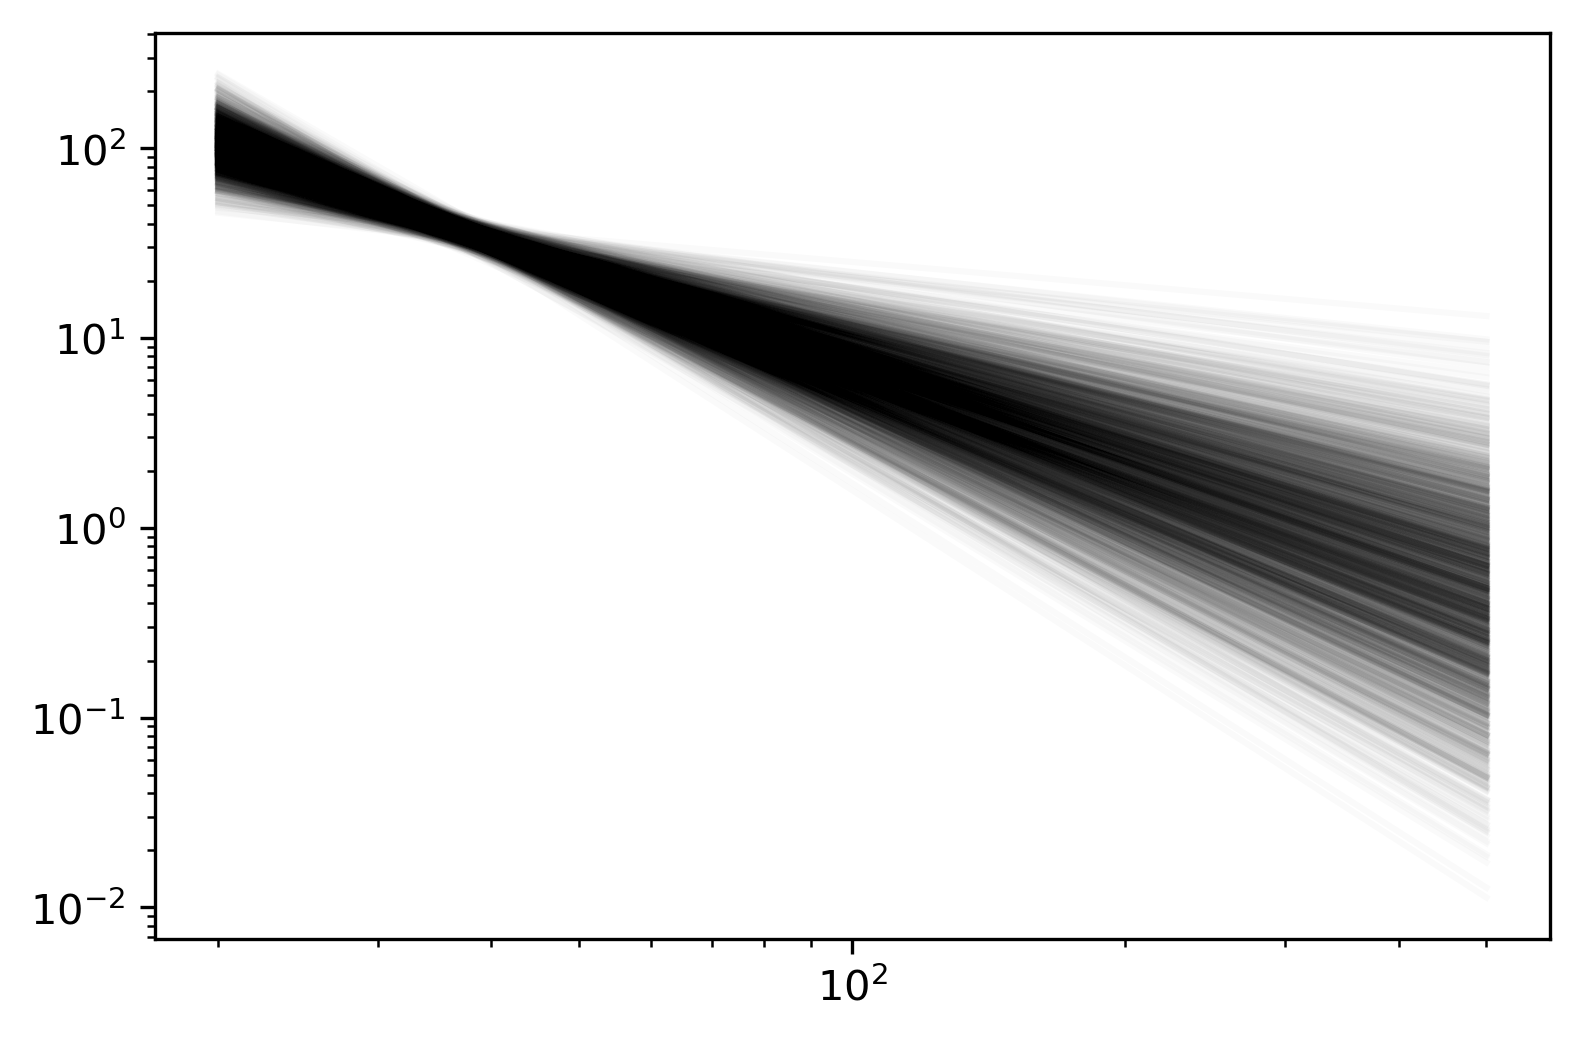

In [11]:
dist = plt.plot(p,μ,c='k',alpha=0.02, label="Per Day");
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.plot(p,1500/p,color='C1', label="Per \$2000")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1,200)
plt.xlabel('Price');
plt.ylabel('Purchases');
plt.legend()
#plt.legend()

(100, 10000)

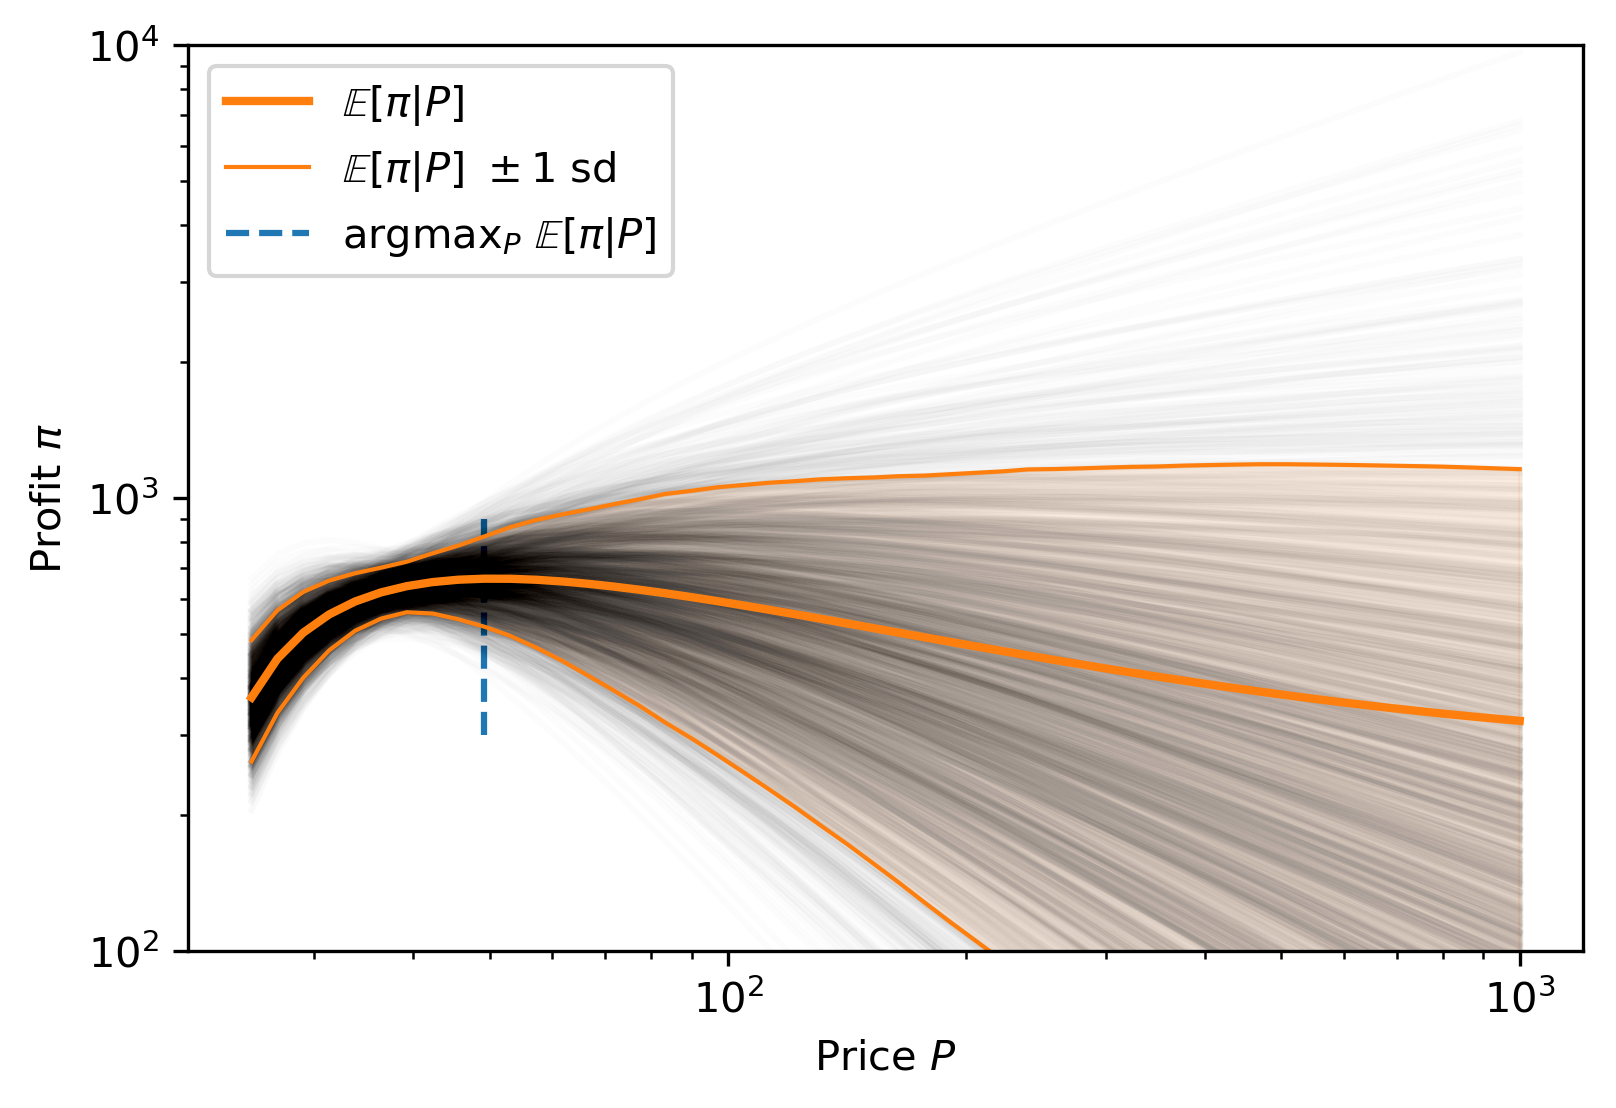

In [8]:
plot(np.logspace(np.log10(25),3))
plt.xscale('log')
plt.yscale('log')
plt.ylim(100,10000)

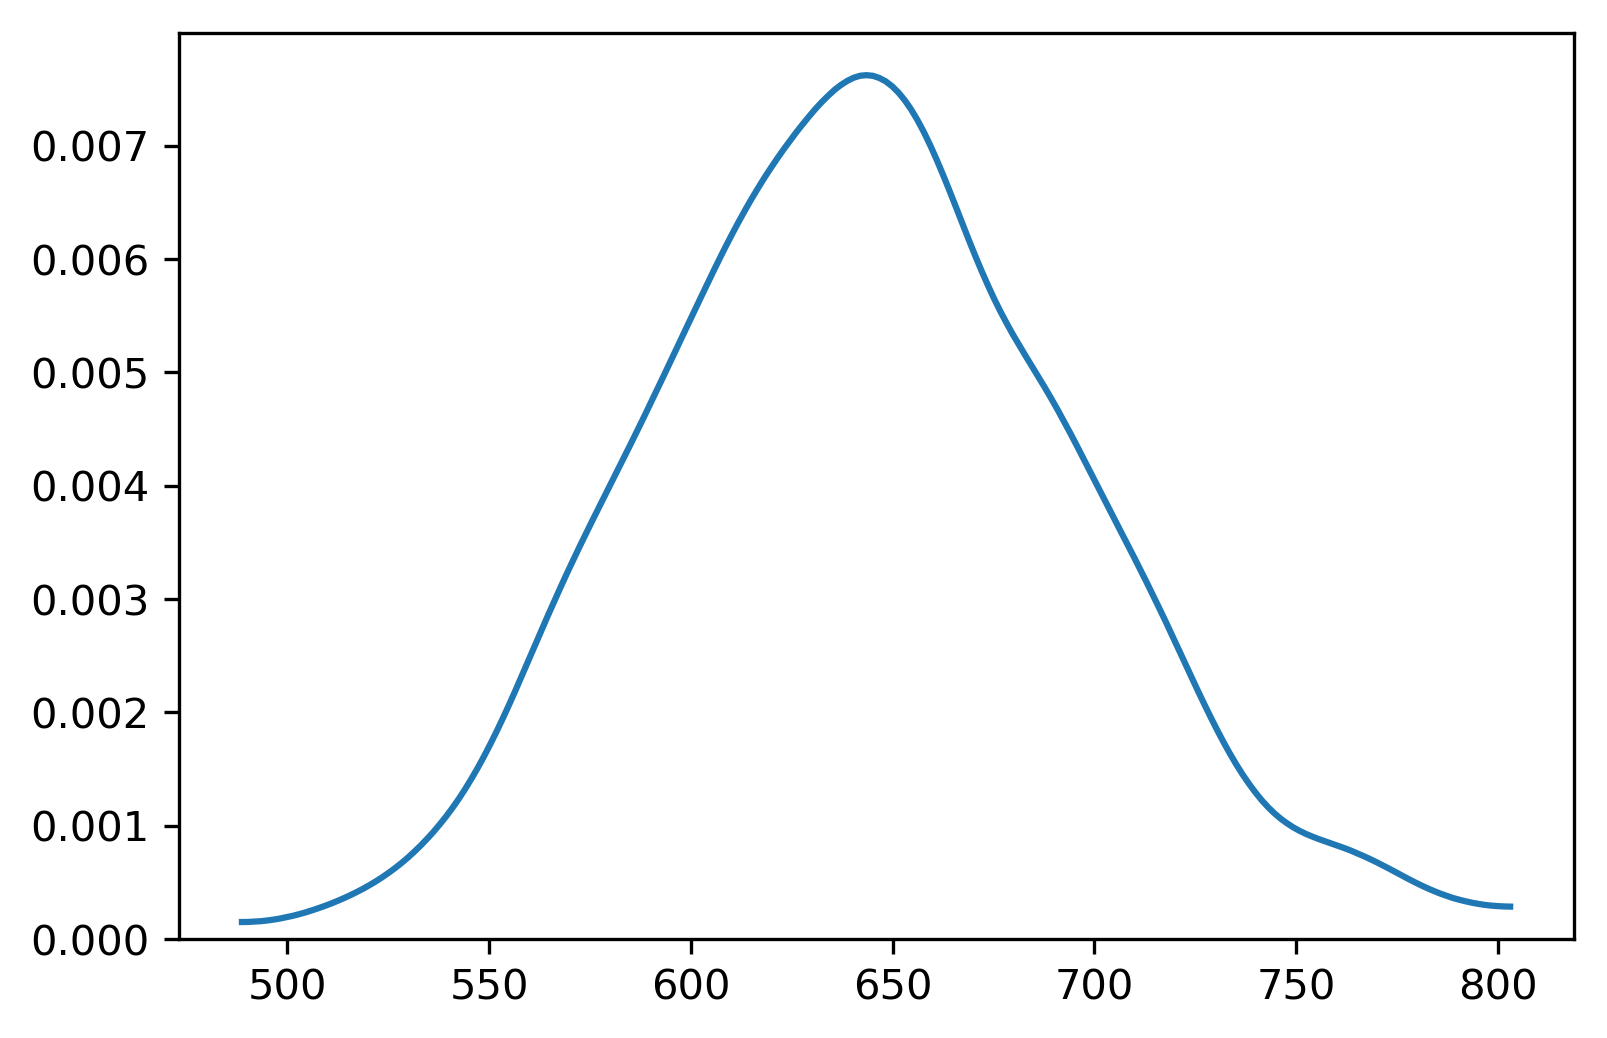

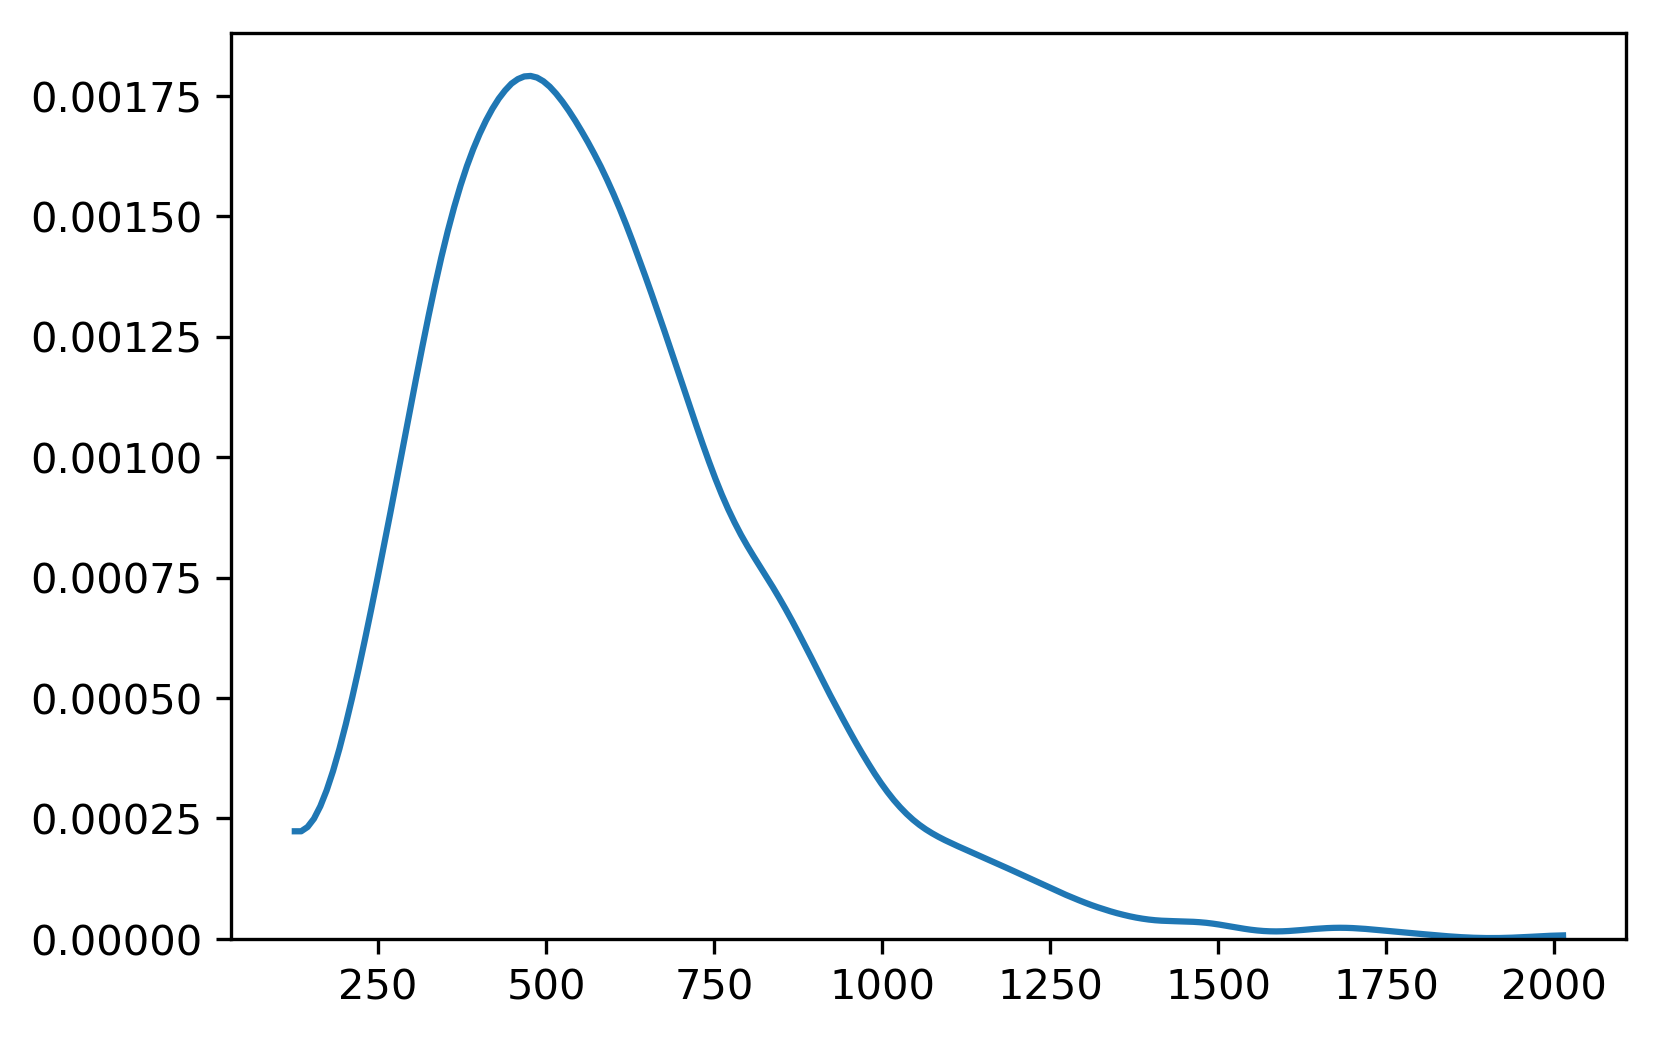

In [27]:
pm.kdeplot(predict(t,np.array(40))[1].ravel());
pm.kdeplot(predict(t,np.array(100))[1].ravel());

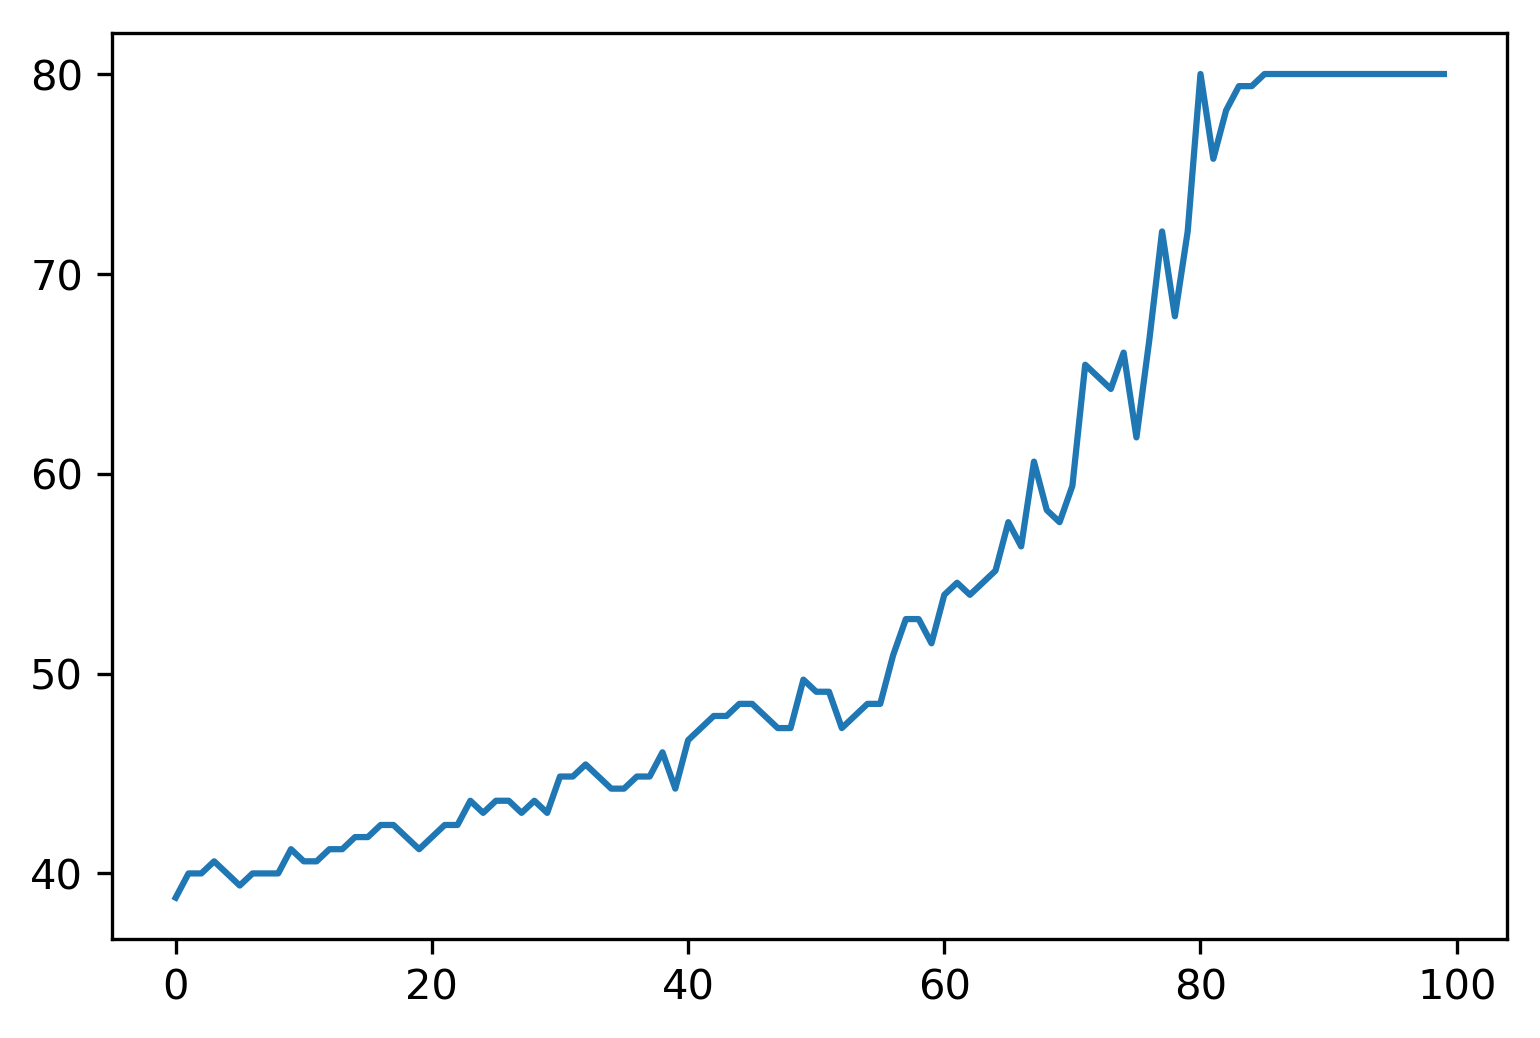

In [10]:
p = np.linspace(20,80,100)
μ,π=predict(t,p)
plt.plot(p[np.argmax(np.percentile(π,np.arange(100),1),1)])

In [11]:
import scipy
np.mean(q0  > np.random.poisson(t['μ0']), 0)

array([ 0.499 ,  0.7185,  0.1035,  0.457 ,  0.6585])

In [12]:
p[np.argmax(np.mean(π,1))]

50.909090909090907

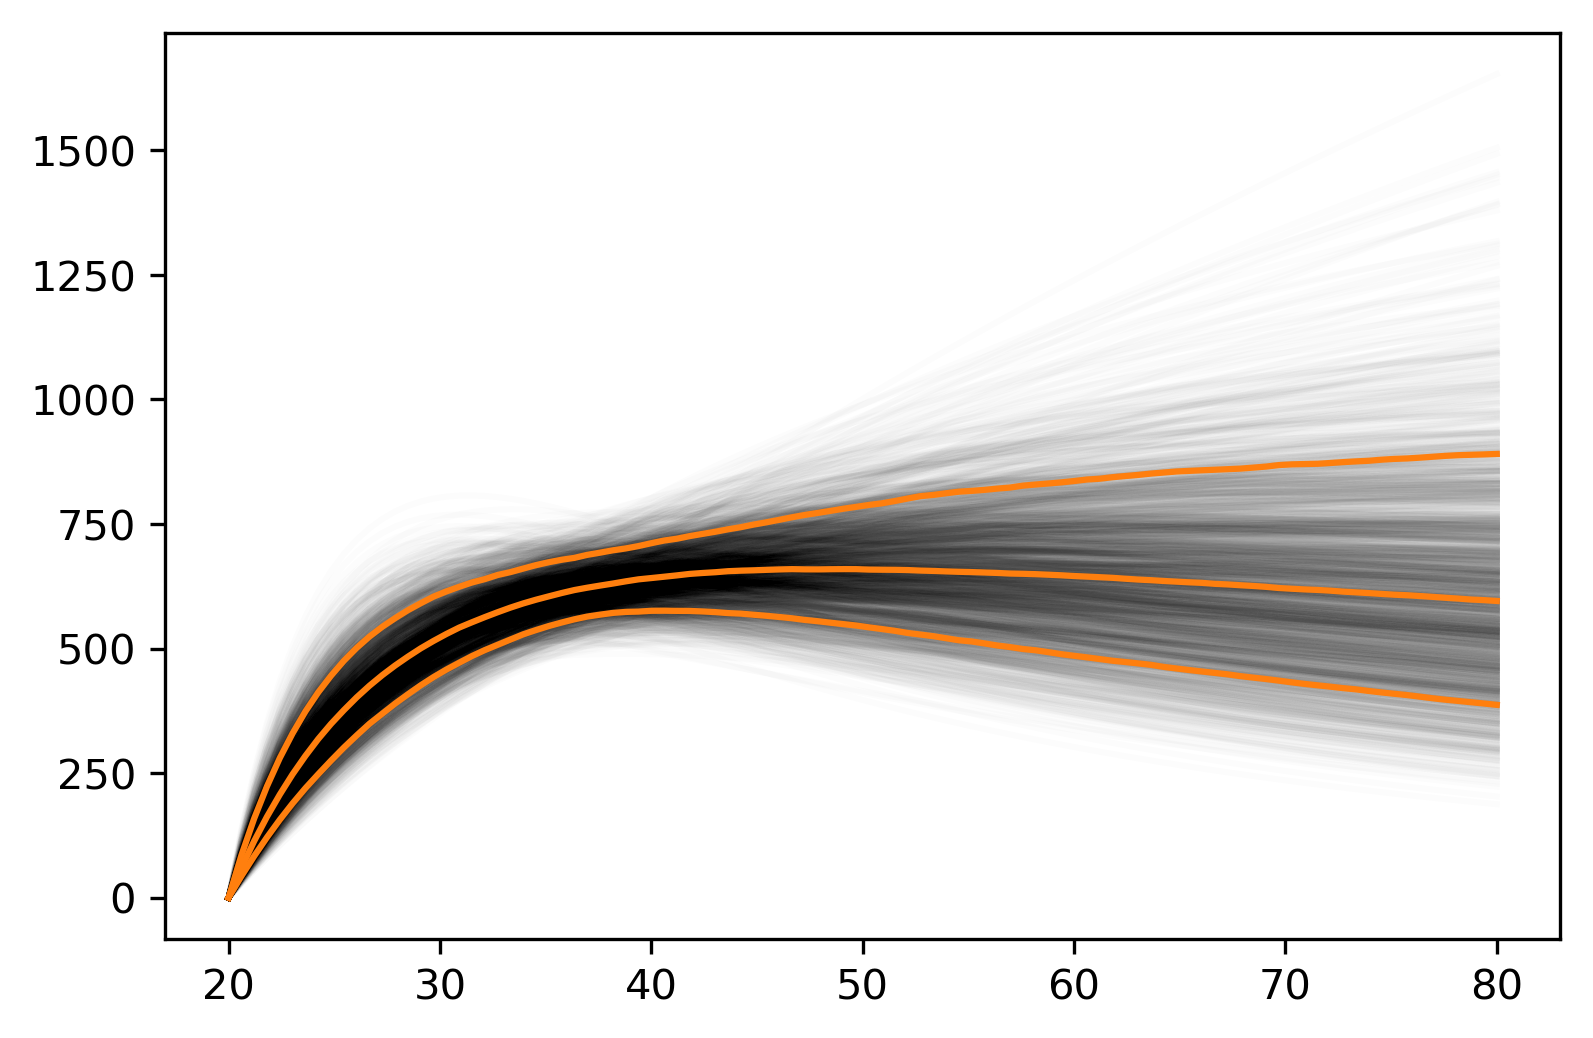

In [13]:
plt.plot(p,π,c='k',alpha=0.01);

plt.plot(p,np.percentile(π,[10,50,90],1).T,c='C1');
#plt.plot(p,(p - k) * eq)
#plt.ylim(400,800);

Maximize probability of making at least ...

In [14]:
lo = np.linspace(np.max(np.min(π,1)),800)
m = np.zeros_like(lo)
for (j,πmin) in enumerate(lo):
    m[j] = p[np.argmax(np.mean(π>πmin,1))]

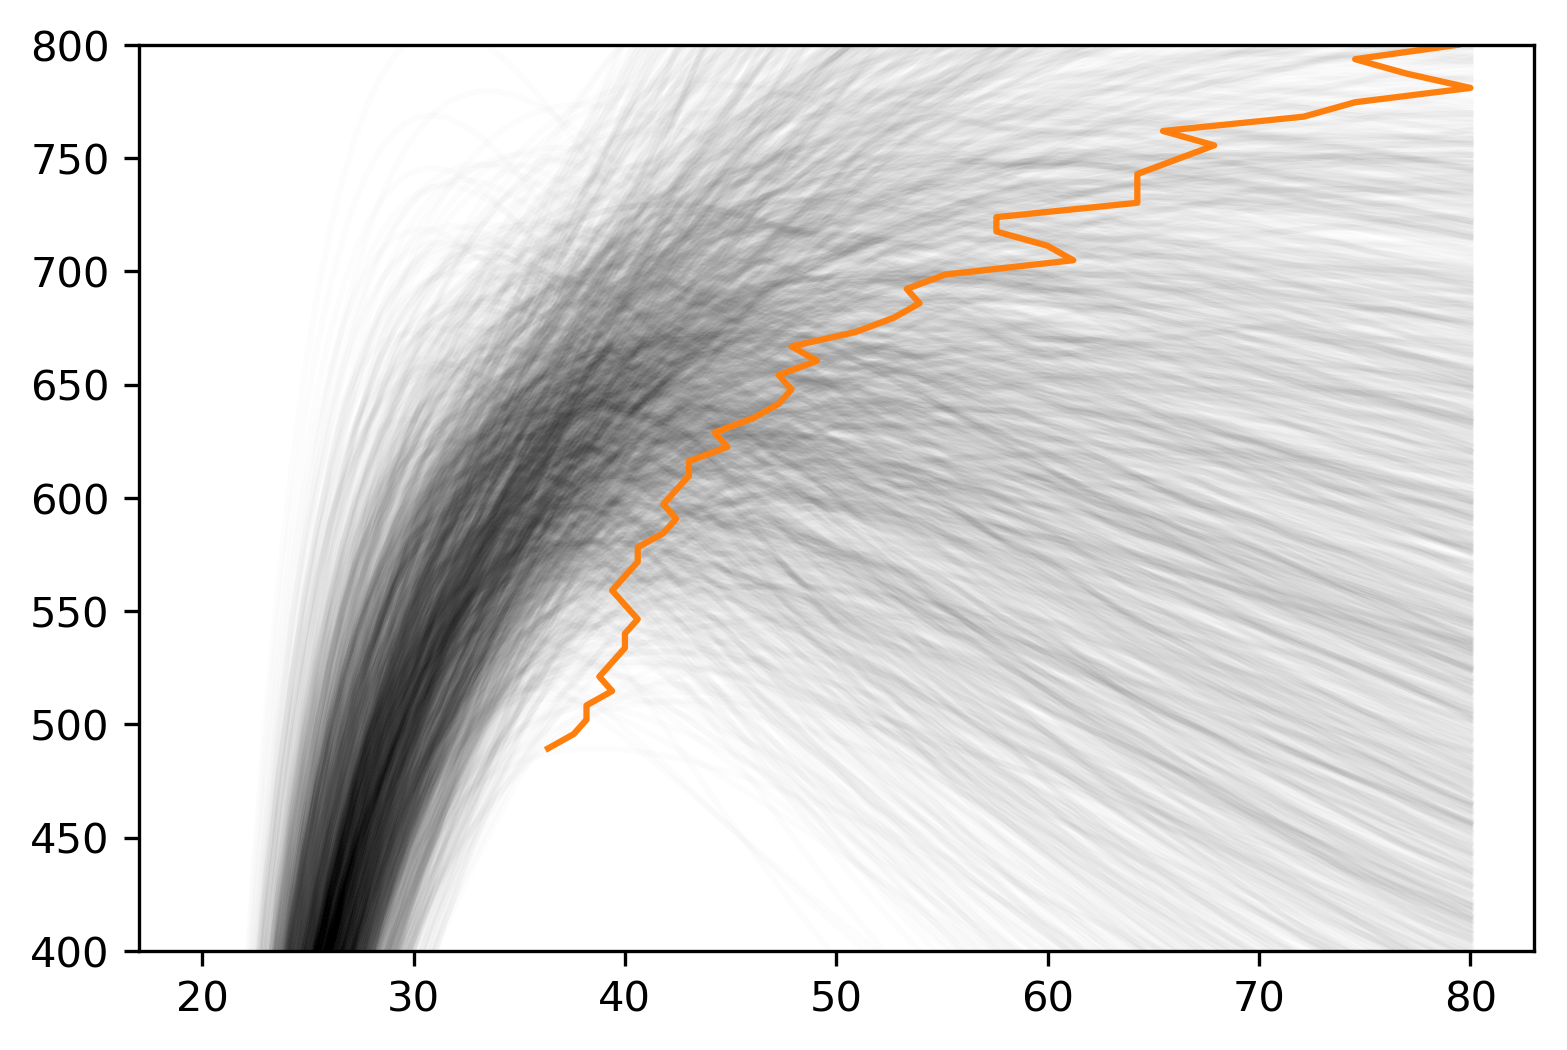

In [15]:
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(m,lo,c='C1')
plt.ylim(400,800);

In [16]:
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


In [ ]:
plt.plot(p,μ,c='k',alpha=0.01);
plt.plot(p0,q0,'o',c='C1');
plt.plot(p,eq)
plt.ylim(10,70);

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/chad/.local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/chad/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/chad/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/chad/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/chad/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/chad/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/c

In [ ]:
plt.plot(p,π,c='k',alpha=0.01);
#plt.plot(p,np.mean(π,1).T,c='C1',lw=2);
plt.plot(p0,(p0-k)*q0,'o',c='C1',lw=2);
plt.plot(p,(p - k) * eq)
plt.ylim(400,800);

In [ ]:
plt.plot(p[np.argmax(π,0)],np.max(π,0),'.')

In [ ]:
np.median(p[np.argmax(π,0)])

In [ ]:
np.sort(np.log((k*t.β/(t.β+1))[t.β<-1]))[1000]

In [ ]:
plt.plot(t.α,t.β,'.',alpha=0.5)

In [ ]:
phats = np.zeros(10)
for i in range(10):
    j=np.random.randint(2000)
    

In [ ]:
t.α[6] + t.β[6] * (np.log(p0) - np.log(p0).mean())

In [ ]:
t.μ0

In [ ]:
t.α.ravel().shape

In [ ]:
def simsales(α,β,p):
    logμ0 = α + β * (np.log(p) - np.log(p0).mean())
    return np.random.poisson(np.exp(logμ0))
        
def fitprices(p0,q0,draws=500):
    with pm.Model() as m2:
        α = pm.Cauchy('α',0,5)
        β = pm.Cauchy('β',0,5)
        logμ0 = α + β * (np.log(p0) - np.log(p0).mean())
        μ0 = pm.Deterministic('μ0',np.exp(logμ0))
        qval = pm.Poisson('q0',μ0,observed=q0)
        
        return pm.sample(draws=draws)
    
def bestprice(t):
    p  = np.linspace(25,55)
    μ = np.exp(t.α + t.β * (np.log(p).reshape(-1,1) - np.log(p0).mean()))
    π = (p - k).reshape(-1,1) * μ
    
    phat = p[np.argmax(np.mean(π,1))]
    μhat = np.exp(t.α + t.β * (np.log(phat).reshape(-1,1) - np.log(p0).mean())).mean()
    πhat = (phat - k).reshape(-1,1) * μhat

In [ ]:
plt.plot(p,simsales(t.α[3],t.β[3],p),'.',alpha=0.5)

In [ ]:
p

In [ ]:
np.log(p)